In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import pathlib
import pickle
import random
import time

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.functional import interpolate
from torch.utils.data import DataLoader
from torchvision.transforms.functional import adjust_brightness

from super_resolution.src.sen2venus_dataset import (
    create_train_test_split,
    create_train_validation_test_split,
    default_patch_transform,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, TruncatedVGG19, Discriminator

In [3]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

In [4]:
sites = {
    "SO2",
    # "ES-LTERA",
    # "FR-LAM",
    # "FR-BIL",
    # "NARYN",
}
train_patches, test_patches = create_train_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(
    f"Num train {len(train_patches)}\n"
    # f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 516
Num test 222


In [5]:
# # Compute data mean and std for channels
# train_patches.set_transform(lambda x, y: (x[:3, :, :], y[:3, :, :]))
# loader = DataLoader(train_patches, batch_size=256)
# channel_means = torch.zeros((3, 1, 1))
# channel_std = torch.zeros((3, 1, 1))
# hr_channel_means = torch.zeros((3, 1, 1))
# hr_channel_std = torch.zeros((3, 1, 1))

# for low_res, high_res in loader:
#     channel_means += torch.mean(low_res, (0, 2, 3), keepdim=True).squeeze(0)
#     channel_std += torch.std(low_res, (0, 2, 3), keepdim=True).squeeze(0)
#     hr_channel_means += torch.mean(high_res, (0, 2, 3), keepdim=True).squeeze(0)
#     hr_channel_std += torch.std(high_res, (0, 2, 3), keepdim=True).squeeze(0)

# channel_means /= len(loader)
# channel_std /= len(loader)
# hr_channel_means /= len(loader)
# hr_channel_std /= len(loader)

In [6]:
# channel_means, hr_channel_means

In [7]:
# channel_std, hr_channel_std

In [8]:
def channel_scale(x):
    x = x[:3, :, :]
    x_channel_max = x.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
    x_channel_min = x.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)

    x = (x - x_channel_min) / (x_channel_max - x_channel_min)

    return x


def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = torch.clamp(x, 0, 1)
    y = torch.clamp(y, 0, 1)

    return x, y

In [9]:
train_patches.set_transform(image_transform)
test_patches.set_transform(image_transform)

In [10]:
train_loader = DataLoader(train_patches, batch_size=100)

In [11]:
(low_res, high_res) = next(train_loader.__iter__())

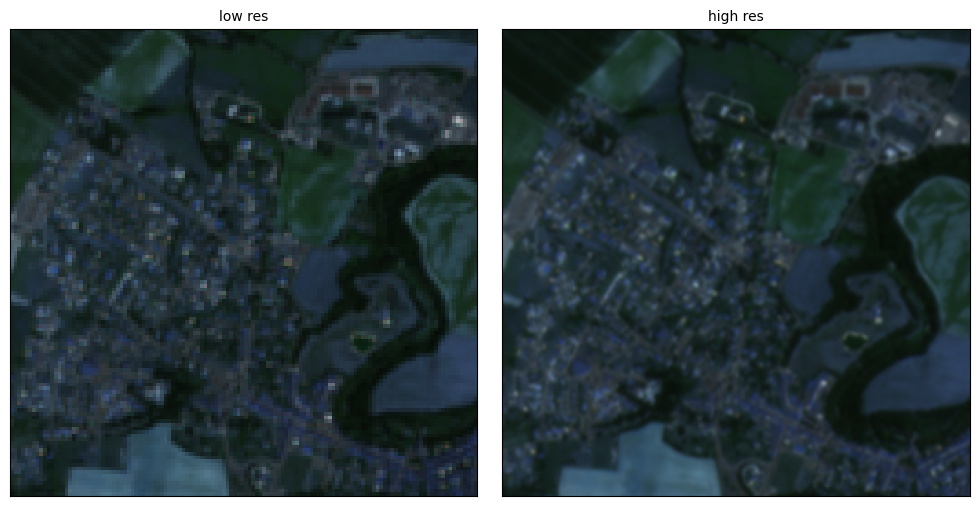

In [12]:
index = random.randint(0, len(low_res) - 1)
low_res_example = low_res[index]


high_res_example = high_res[index]


plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

In [ ]:
# For clearing GPU memory
1 / 0

In [ ]:
# For clearing GPU memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,  # Always set to true for training
    batch_size=16,  # Always try to set as powers of 2
    drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
    pin_memory=should_pin_memory[device.type],  # Faster push to GPU
    num_workers=0,  # Load data in parallel but costs more memory
)

In [161]:
device

device(type='cuda')

In [162]:
generator = SRResNet(scaling_factor=2, n_blocks=4)
discriminator = Discriminator(n_blocks=2, fc_size=128)

In [189]:
generator = generator.to(device)
generator = generator.train()

In [164]:
discriminator = discriminator.to(device)
discriminator = discriminator.train()

In [165]:
gen_optimizer = optim.Adam(generator.parameters(), lr=0.000001, weight_decay=0.0000001)
discrim_optimizer = optim.Adam(
    discriminator.parameters(), lr=0.000001, weight_decay=0.0000001
)

In [166]:
pixel_criterion = nn.MSELoss()
discrim_criterion = nn.BCEWithLogitsLoss()

In [167]:
# vgg = TruncatedVGG19().to(device)
# vgg = vgg.eval()
# vgg = vgg.requires_grad_(False)

In [168]:
NUM_EPOCHS = 200

In [169]:
train_time = 0.0
gen_losses = []
discrim_losses = []

In [190]:
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    gen_epoch_loss = 0.0
    discrim_epoch_loss = 0.0
    for low_res_batch, high_res_batch in progress_bar:
        start_time = time.time()

        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        # Update generator
        ############################################################################################
        super_resolved = generator(low_res_batch).clamp(0, 1)
        natural_probs = discriminator(super_resolved)

        pixel_loss = pixel_criterion(super_resolved, high_res_batch)
        discrim_loss = discrim_criterion(natural_probs, torch.ones_like(natural_probs))
        gen_loss = pixel_loss + 1e-3 * discrim_loss

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # Update discriminator
        ############################################################################################
        true_natural_probs = discriminator(high_res_batch)

        # Detach to skip generator computations
        fake_natural_probs = discriminator(super_resolved.detach())

        true_natural_loss = discrim_criterion(
            true_natural_probs, torch.ones_like(true_natural_probs)
        )
        fake_natural_loss = discrim_criterion(
            fake_natural_probs, torch.ones_like(fake_natural_probs)
        )
        adversarial_loss = true_natural_loss + fake_natural_loss

        # Do not let discrim get too much advantage
        if adversarial_loss.item() > 1e-04:
            discrim_optimizer.zero_grad()
            adversarial_loss.backward()
            discrim_optimizer.step()

        # Collect data
        gen_epoch_loss += gen_loss.item()
        discrim_epoch_loss += discrim_loss.item()
        progress_bar.set_postfix(epoch=epoch)

        end_time = time.time()
        train_time += end_time - start_time

    gen_epoch_loss /= len(train_loader)
    discrim_epoch_loss /= len(train_loader)
    gen_losses.append(gen_epoch_loss)
    discrim_losses.append(discrim_epoch_loss)
    print(
        f"Epoch: {epoch} / gen_loss: {gen_epoch_loss:.8f} / discrim_loss: {discrim_epoch_loss:.6f}"
    )

100%|██████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.31it/s, epoch=0]


Epoch: 0 / gen_loss: 0.00135003 / discrim_loss: 0.029843


100%|██████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.36it/s, epoch=1]


Epoch: 1 / gen_loss: 0.00132563 / discrim_loss: 0.029003


100%|██████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=2]


Epoch: 2 / gen_loss: 0.00129449 / discrim_loss: 0.028573


100%|██████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=3]


Epoch: 3 / gen_loss: 0.00129177 / discrim_loss: 0.027767


100%|██████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=4]


Epoch: 4 / gen_loss: 0.00125598 / discrim_loss: 0.027535


100%|██████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=5]


Epoch: 5 / gen_loss: 0.00120469 / discrim_loss: 0.027328


100%|██████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=6]


Epoch: 6 / gen_loss: 0.00117436 / discrim_loss: 0.026887


100%|██████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=7]


Epoch: 7 / gen_loss: 0.00115017 / discrim_loss: 0.026644


100%|██████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=8]


Epoch: 8 / gen_loss: 0.00111149 / discrim_loss: 0.026199


100%|██████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=9]


Epoch: 9 / gen_loss: 0.00109079 / discrim_loss: 0.025714


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=10]


Epoch: 10 / gen_loss: 0.00105870 / discrim_loss: 0.025293


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=11]


Epoch: 11 / gen_loss: 0.00104528 / discrim_loss: 0.024787


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=12]


Epoch: 12 / gen_loss: 0.00102893 / discrim_loss: 0.024157


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=13]


Epoch: 13 / gen_loss: 0.00098983 / discrim_loss: 0.023953


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=14]


Epoch: 14 / gen_loss: 0.00097828 / discrim_loss: 0.022967


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=15]


Epoch: 15 / gen_loss: 0.00096180 / discrim_loss: 0.022806


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=16]


Epoch: 16 / gen_loss: 0.00094384 / discrim_loss: 0.022210


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=17]


Epoch: 17 / gen_loss: 0.00092009 / discrim_loss: 0.021920


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=18]


Epoch: 18 / gen_loss: 0.00092823 / discrim_loss: 0.021120


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=19]


Epoch: 19 / gen_loss: 0.00090481 / discrim_loss: 0.020516


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=20]


Epoch: 20 / gen_loss: 0.00087375 / discrim_loss: 0.020437


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=21]


Epoch: 21 / gen_loss: 0.00086059 / discrim_loss: 0.020036


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=22]


Epoch: 22 / gen_loss: 0.00085313 / discrim_loss: 0.019546


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=23]


Epoch: 23 / gen_loss: 0.00083320 / discrim_loss: 0.019203


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=24]


Epoch: 24 / gen_loss: 0.00082068 / discrim_loss: 0.018900


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=25]


Epoch: 25 / gen_loss: 0.00081138 / discrim_loss: 0.018471


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=26]


Epoch: 26 / gen_loss: 0.00078955 / discrim_loss: 0.018093


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=27]


Epoch: 27 / gen_loss: 0.00077980 / discrim_loss: 0.017719


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=28]


Epoch: 28 / gen_loss: 0.00075608 / discrim_loss: 0.017269


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=29]


Epoch: 29 / gen_loss: 0.00075715 / discrim_loss: 0.017332


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=30]


Epoch: 30 / gen_loss: 0.00073763 / discrim_loss: 0.016807


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=31]


Epoch: 31 / gen_loss: 0.00072803 / discrim_loss: 0.016457


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=32]


Epoch: 32 / gen_loss: 0.00071985 / discrim_loss: 0.016241


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=33]


Epoch: 33 / gen_loss: 0.00072621 / discrim_loss: 0.015758


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=34]


Epoch: 34 / gen_loss: 0.00070156 / discrim_loss: 0.015449


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=35]


Epoch: 35 / gen_loss: 0.00068255 / discrim_loss: 0.015230


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=36]


Epoch: 36 / gen_loss: 0.00067841 / discrim_loss: 0.014799


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=37]


Epoch: 37 / gen_loss: 0.00066868 / discrim_loss: 0.014567


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=38]


Epoch: 38 / gen_loss: 0.00065782 / discrim_loss: 0.014214


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=39]


Epoch: 39 / gen_loss: 0.00065418 / discrim_loss: 0.014019


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=40]


Epoch: 40 / gen_loss: 0.00064357 / discrim_loss: 0.013714


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=41]


Epoch: 41 / gen_loss: 0.00063976 / discrim_loss: 0.013345


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=42]


Epoch: 42 / gen_loss: 0.00062245 / discrim_loss: 0.013195


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=43]


Epoch: 43 / gen_loss: 0.00060600 / discrim_loss: 0.012914


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=44]


Epoch: 44 / gen_loss: 0.00059649 / discrim_loss: 0.012748


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=45]


Epoch: 45 / gen_loss: 0.00058562 / discrim_loss: 0.012356


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=46]


Epoch: 46 / gen_loss: 0.00057874 / discrim_loss: 0.012373


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=47]


Epoch: 47 / gen_loss: 0.00057946 / discrim_loss: 0.011921


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=48]


Epoch: 48 / gen_loss: 0.00056294 / discrim_loss: 0.011712


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=49]


Epoch: 49 / gen_loss: 0.00055959 / discrim_loss: 0.011686


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=50]


Epoch: 50 / gen_loss: 0.00054740 / discrim_loss: 0.011257


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=51]


Epoch: 51 / gen_loss: 0.00054462 / discrim_loss: 0.011149


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=52]


Epoch: 52 / gen_loss: 0.00054133 / discrim_loss: 0.010847


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=53]


Epoch: 53 / gen_loss: 0.00053320 / discrim_loss: 0.010507


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=54]


Epoch: 54 / gen_loss: 0.00051616 / discrim_loss: 0.010533


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=55]


Epoch: 55 / gen_loss: 0.00051335 / discrim_loss: 0.010168


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.33it/s, epoch=56]


Epoch: 56 / gen_loss: 0.00050872 / discrim_loss: 0.009872


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=57]


Epoch: 57 / gen_loss: 0.00050545 / discrim_loss: 0.009924


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=58]


Epoch: 58 / gen_loss: 0.00050076 / discrim_loss: 0.009639


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=59]


Epoch: 59 / gen_loss: 0.00049474 / discrim_loss: 0.009308


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=60]


Epoch: 60 / gen_loss: 0.00048979 / discrim_loss: 0.009163


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=61]


Epoch: 61 / gen_loss: 0.00048312 / discrim_loss: 0.009074


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=62]


Epoch: 62 / gen_loss: 0.00047530 / discrim_loss: 0.008859


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=63]


Epoch: 63 / gen_loss: 0.00046781 / discrim_loss: 0.008748


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=64]


Epoch: 64 / gen_loss: 0.00047727 / discrim_loss: 0.008560


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=65]


Epoch: 65 / gen_loss: 0.00045988 / discrim_loss: 0.008333


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=66]


Epoch: 66 / gen_loss: 0.00045300 / discrim_loss: 0.008272


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=67]


Epoch: 67 / gen_loss: 0.00044616 / discrim_loss: 0.007970


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=68]


Epoch: 68 / gen_loss: 0.00044245 / discrim_loss: 0.007826


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=69]


Epoch: 69 / gen_loss: 0.00044595 / discrim_loss: 0.007712


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=70]


Epoch: 70 / gen_loss: 0.00042847 / discrim_loss: 0.007543


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=71]


Epoch: 71 / gen_loss: 0.00043019 / discrim_loss: 0.007599


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=72]


Epoch: 72 / gen_loss: 0.00042705 / discrim_loss: 0.007318


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=73]


Epoch: 73 / gen_loss: 0.00041953 / discrim_loss: 0.007125


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.33it/s, epoch=74]


Epoch: 74 / gen_loss: 0.00041159 / discrim_loss: 0.007105


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=75]


Epoch: 75 / gen_loss: 0.00041089 / discrim_loss: 0.006967


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=76]


Epoch: 76 / gen_loss: 0.00041642 / discrim_loss: 0.006671


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=77]


Epoch: 77 / gen_loss: 0.00041093 / discrim_loss: 0.006727


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=78]


Epoch: 78 / gen_loss: 0.00040120 / discrim_loss: 0.006468


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=79]


Epoch: 79 / gen_loss: 0.00039958 / discrim_loss: 0.006389


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=80]


Epoch: 80 / gen_loss: 0.00039249 / discrim_loss: 0.006318


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=81]


Epoch: 81 / gen_loss: 0.00038511 / discrim_loss: 0.006183


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=82]


Epoch: 82 / gen_loss: 0.00038186 / discrim_loss: 0.005990


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=83]


Epoch: 83 / gen_loss: 0.00037704 / discrim_loss: 0.005995


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=84]


Epoch: 84 / gen_loss: 0.00038859 / discrim_loss: 0.005855


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=85]


Epoch: 85 / gen_loss: 0.00038712 / discrim_loss: 0.005711


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=86]


Epoch: 86 / gen_loss: 0.00036877 / discrim_loss: 0.005689


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=87]


Epoch: 87 / gen_loss: 0.00036683 / discrim_loss: 0.005547


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=88]


Epoch: 88 / gen_loss: 0.00036193 / discrim_loss: 0.005267


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=89]


Epoch: 89 / gen_loss: 0.00035754 / discrim_loss: 0.005450


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=90]


Epoch: 90 / gen_loss: 0.00036278 / discrim_loss: 0.005189


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=91]


Epoch: 91 / gen_loss: 0.00035267 / discrim_loss: 0.005080


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=92]


Epoch: 92 / gen_loss: 0.00034094 / discrim_loss: 0.005039


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=93]


Epoch: 93 / gen_loss: 0.00034265 / discrim_loss: 0.005006


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=94]


Epoch: 94 / gen_loss: 0.00034570 / discrim_loss: 0.004820


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=95]


Epoch: 95 / gen_loss: 0.00035280 / discrim_loss: 0.004724


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=96]


Epoch: 96 / gen_loss: 0.00033099 / discrim_loss: 0.004672


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=97]


Epoch: 97 / gen_loss: 0.00032782 / discrim_loss: 0.004691


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=98]


Epoch: 98 / gen_loss: 0.00033104 / discrim_loss: 0.004545


100%|█████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=99]


Epoch: 99 / gen_loss: 0.00033173 / discrim_loss: 0.004503


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.33it/s, epoch=100]


Epoch: 100 / gen_loss: 0.00033130 / discrim_loss: 0.004356


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=101]


Epoch: 101 / gen_loss: 0.00032896 / discrim_loss: 0.004211


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=102]


Epoch: 102 / gen_loss: 0.00031877 / discrim_loss: 0.004202


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=103]


Epoch: 103 / gen_loss: 0.00031685 / discrim_loss: 0.004090


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=104]


Epoch: 104 / gen_loss: 0.00031864 / discrim_loss: 0.004081


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=105]


Epoch: 105 / gen_loss: 0.00031705 / discrim_loss: 0.003892


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=106]


Epoch: 106 / gen_loss: 0.00031111 / discrim_loss: 0.003900


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=107]


Epoch: 107 / gen_loss: 0.00031135 / discrim_loss: 0.003699


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=108]


Epoch: 108 / gen_loss: 0.00030541 / discrim_loss: 0.003771


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=109]


Epoch: 109 / gen_loss: 0.00031842 / discrim_loss: 0.003705


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=110]


Epoch: 110 / gen_loss: 0.00029878 / discrim_loss: 0.003557


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=111]


Epoch: 111 / gen_loss: 0.00029438 / discrim_loss: 0.003524


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=112]


Epoch: 112 / gen_loss: 0.00030167 / discrim_loss: 0.003477


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=113]


Epoch: 113 / gen_loss: 0.00029546 / discrim_loss: 0.003446


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=114]


Epoch: 114 / gen_loss: 0.00029767 / discrim_loss: 0.003279


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=115]


Epoch: 115 / gen_loss: 0.00028936 / discrim_loss: 0.003249


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=116]


Epoch: 116 / gen_loss: 0.00030310 / discrim_loss: 0.003313


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=117]


Epoch: 117 / gen_loss: 0.00029177 / discrim_loss: 0.003149


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=118]


Epoch: 118 / gen_loss: 0.00028800 / discrim_loss: 0.003098


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=119]


Epoch: 119 / gen_loss: 0.00028021 / discrim_loss: 0.003068


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=120]


Epoch: 120 / gen_loss: 0.00028155 / discrim_loss: 0.002901


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=121]


Epoch: 121 / gen_loss: 0.00027635 / discrim_loss: 0.003027


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=122]


Epoch: 122 / gen_loss: 0.00028552 / discrim_loss: 0.002913


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=123]


Epoch: 123 / gen_loss: 0.00027845 / discrim_loss: 0.002822


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=124]


Epoch: 124 / gen_loss: 0.00027013 / discrim_loss: 0.002901


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s, epoch=125]


Epoch: 125 / gen_loss: 0.00027640 / discrim_loss: 0.002780


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s, epoch=126]


Epoch: 126 / gen_loss: 0.00026671 / discrim_loss: 0.002681


100%|████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.32it/s, epoch=127]


Epoch: 127 / gen_loss: 0.00026553 / discrim_loss: 0.002618


 41%|█████████████████████▏                              | 13/32 [00:05<00:08,  2.18it/s, epoch=128]


KeyboardInterrupt: 

In [171]:
train_time / 60

14.999590734640757

In [172]:
len(gen_losses)

77

In [173]:
gen_losses[-5:]

[0.0015172864332271274,
 0.0014918633205525111,
 0.0014612771701649763,
 0.001427324503310956,
 0.001411362627550261]

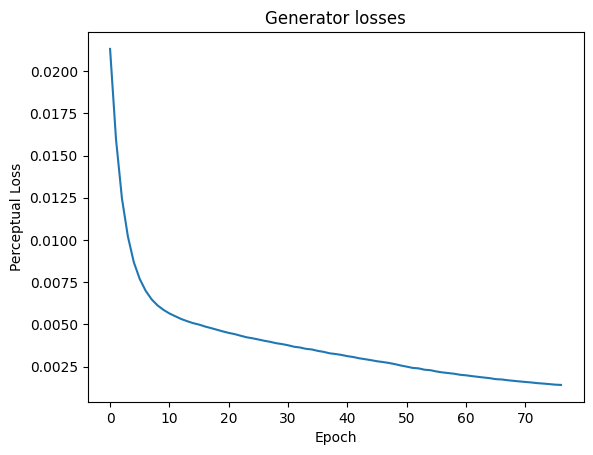

In [174]:
plt.plot(gen_losses)
plt.title("Generator losses")
plt.xlabel("Epoch")
plt.ylabel("Perceptual Loss")
plt.show()

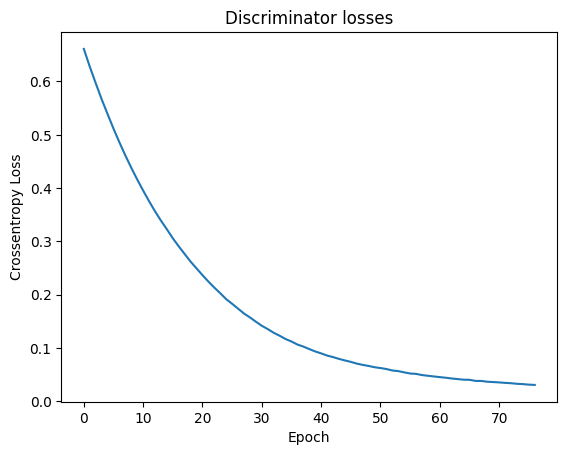

In [175]:
plt.plot(discrim_losses)
plt.title("Discriminator losses")
plt.xlabel("Epoch")
plt.ylabel("Crossentropy Loss")
plt.show()

In [143]:
experiment = {
    "epoch_losses": epoch_losses,
    "batch_losses": losses,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}

In [12]:
save_file = RESULTS_DIR / "abcdiversesites33epochs.pkl"

In [36]:
if not save_file.exists():
    torch.save(experiment, save_file)

In [16]:
# device="cpu"

In [13]:
loaded_experiment = torch.load(save_file, map_location="cpu")

In [16]:
model = SRResNet(scaling_factor=2, n_blocks=4).to(device)
model.load_state_dict((loaded_experiment["model_state"]))
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
optimizer.load_state_dict(loaded_experiment["optimizer_state"])
epoch_losses = loaded_experiment["epoch_losses"]
batch_losses = loaded_experiment["batch_losses"]

In [176]:
generator = generator.to("cpu")

In [177]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(loader.__iter__())

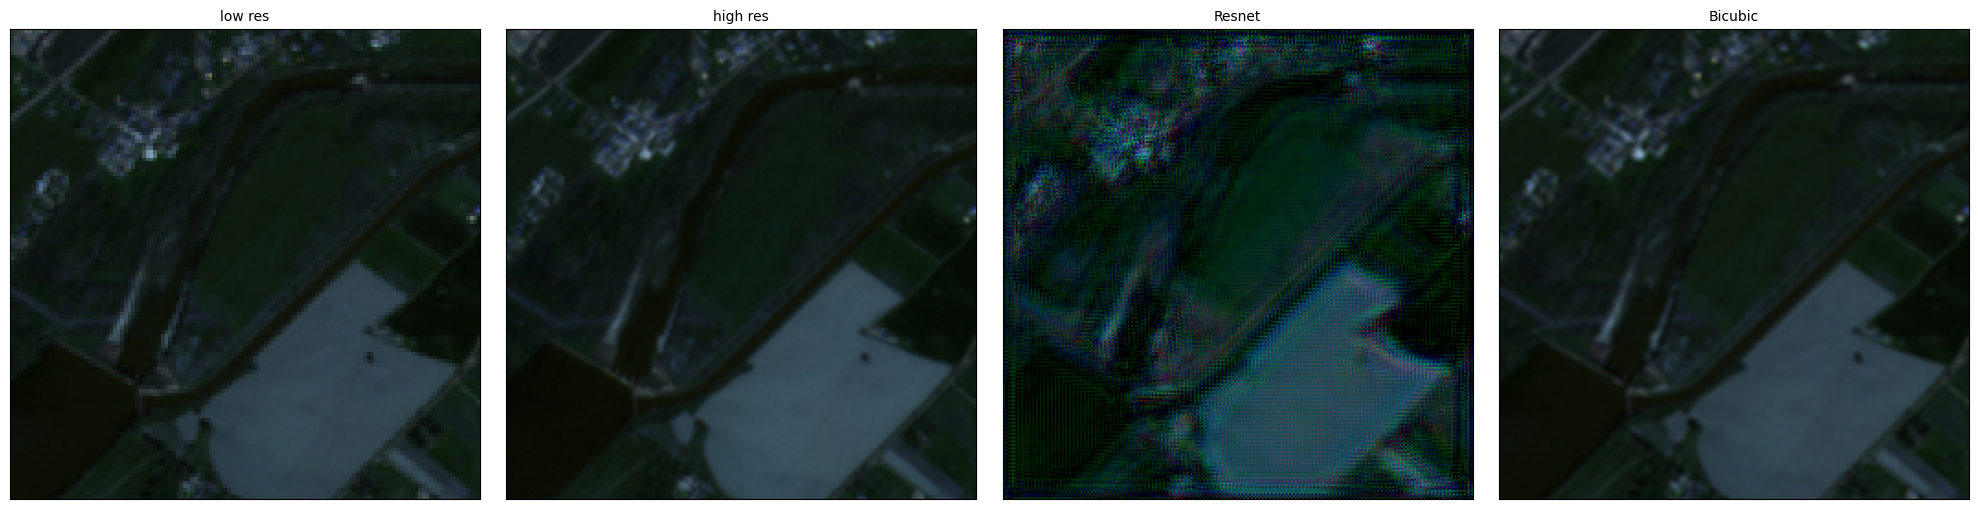

In [183]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = interpolate(
    low_res_example.unsqueeze(0),
    size=(256, 256),
    mode="bicubic",
).float()
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [184]:
loader = DataLoader(test_patches, batch_size=100)
(low_res, high_res) = next(loader.__iter__())

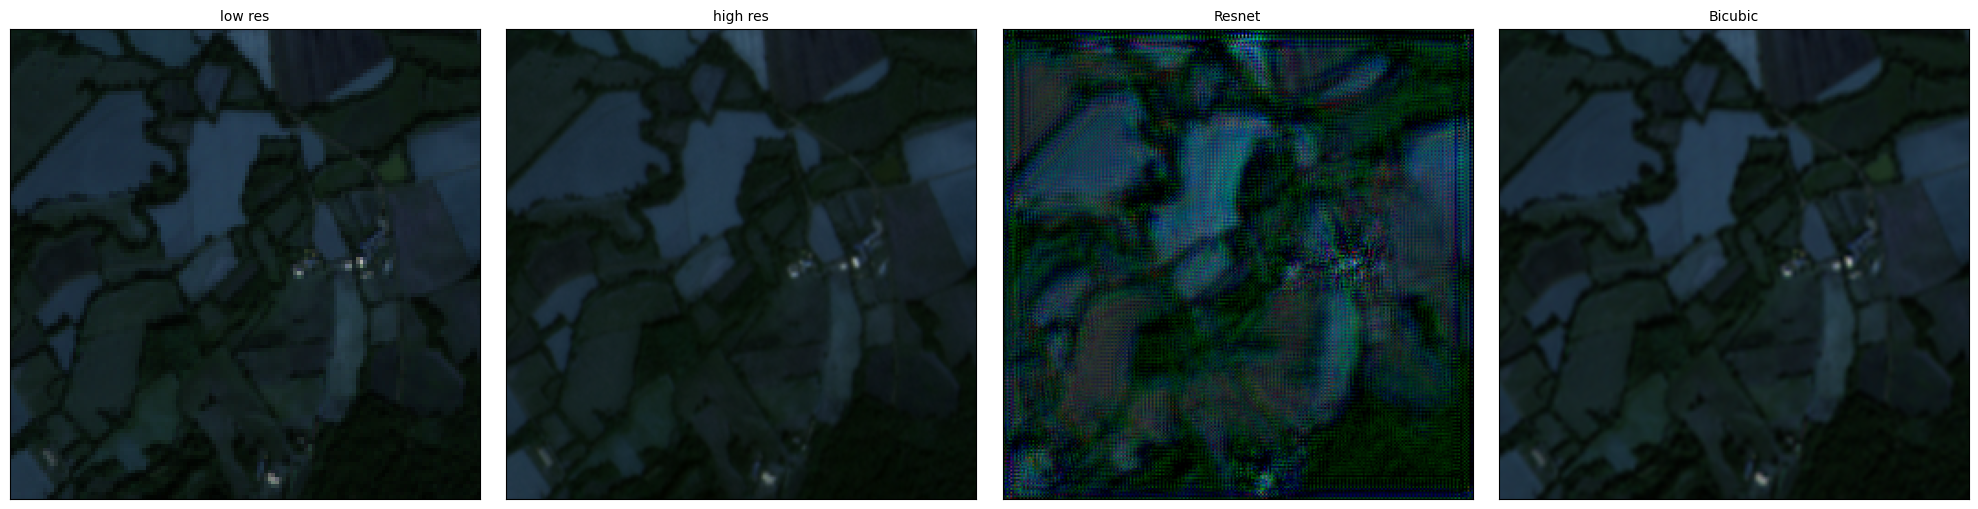

In [188]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = (
    interpolate(low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic")
    .float()
    .clamp(0, 1)
)
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [126]:
from super_resolution.src.testing import compute_metrics

In [127]:
# 256 is largest I can handle on cpu
metric_loader = DataLoader(test_patches, batch_size=min(len(test_patches), 256))

In [128]:
metrics = compute_metrics(lambda x: generator(x).clamp(0, 1), metric_loader)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.30s/it]


In [129]:
metrics

Metrics(mse=0.00011300158803351223, psnr=39.469154357910156, ssim=0.9430058002471924)

In [64]:
bicubic_metrics = compute_metrics(
    lambda x: interpolate(x, size=(256, 256), mode="bicubic"), metric_loader
)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]


In [65]:
bicubic_metrics

Metrics(mse=5.451372635434382e-05, psnr=42.63494110107422, ssim=0.9822045564651489)